**CUSTOMER SEGMENTATION**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import random

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


col_names = ['user_id', 'gender', 'address', 'store_id', 'trans_id', 'timestamp', 'item_id', 'quantity', 'dollar']
churn = pd.read_csv("./retail-churn.csv", sep = ",", skiprows = 1, names = col_names)
churn.head()

,user_id,gender,address,store_id,trans_id,timestamp,item_id,quantity,dollar
0,101981,F,E,2860,818463,11/1/2000 0:00,4.710000e+12,1,37
1,101981,F,E,2861,818464,11/1/2000 0:00,4.710000e+12,1,17
2,101981,F,E,2862,818465,11/1/2000 0:00,4.710000e+12,1,23
3,101981,F,E,2863,818466,11/1/2000 0:00,4.710000e+12,1,41
4,101981,F,E,2864,818467,11/1/2000 0:00,4.710000e+12,8,288


In [2]:
churn['date'] =  pd.to_datetime(pd.to_datetime(churn['timestamp'], format = '%m/%d/%Y %H:%M').dt.date)
churn_agg = churn.groupby(['user_id', 'date']).agg({'dollar': 'sum', 'quantity': 'sum'})
churn_agg = churn_agg.reset_index()
churn_roll = pd.DataFrame()
churn_roll['dollar_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['dollar'].sum()
churn_roll['quantity_roll_sum_7D'] = churn_agg.groupby('user_id').rolling(window = '7D', on = 'date')['quantity'].sum()
churn_roll = churn_roll.reset_index()
churn_roll['last_visit_ndays'] = churn_agg.groupby('user_id')['date'].diff(periods = 1).dt.days
print(churn_roll.shape)

# Should we impute or drop NaN/NaT in churn_roll['last_visit_ndays']?
imputation_value = churn_roll['last_visit_ndays'].max() # None # 
if imputation_value is None:
    # Drop (Remove all rows with NaN):
    churn_roll.dropna(inplace = True)
    print(churn_roll.shape)
else:
    # Impute (Replace all NaN in last_visit_ndays):
    churn_roll['last_visit_ndays'] = churn_roll['last_visit_ndays'].fillna(imputation_value)

churn_roll.head()

(37058, 5)


,user_id,date,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1113,2000-11-12,420.0,5.0,118.0
1,1113,2000-11-26,558.0,3.0,14.0
2,1113,2000-11-27,1182.0,9.0,1.0
3,1113,2001-01-06,628.0,9.0,40.0
4,1250,2001-02-04,734.0,5.0,118.0


In [3]:
# Number of Clusters = 10
n_clusters = 10

# RFM Features Columns Selected
rfm_features = ['dollar_roll_sum_7D', 'quantity_roll_sum_7D', 'last_visit_ndays']
X = churn_roll[rfm_features]

# Standardizing the Data for Normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# k-means Training Initialize
kmeans = KMeans(n_clusters = n_clusters, random_state = 0, n_init = 10)
kmeans.fit(X_normalized)

# Centroids Normalized
centroids_normalized_scale = kmeans.cluster_centers_

In [4]:
# Clusters Reported in Original Scale - USING MANUAL METHOID

Centroids = pd.DataFrame(centroids_normalized_scale, columns=rfm_features)
Centroids = Centroids * X.std() + X.mean()
print(f"CLUSTERS IN ORIGINAL SCALE (W/ MANUAL METHOID):\n {Centroids}" )

CLUSTERS IN ORIGINAL SCALE (W/ MANUAL METHOID):
    dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
0         3457.610636             34.035572         10.552285
1          597.726143              7.150048        117.260804
2          472.141632              6.306601         10.614680
3        19804.650566            972.812949          3.599462
4        43879.962498            212.067201          9.515671
5         1591.641557             17.979373          8.877964
6         7510.321527             58.623422         22.641824
7         2619.000986             25.398731        115.243552
8        19456.583532             87.351651         12.181396
9          655.182210              7.238684         47.365493


In [5]:
# Clusters Reported in Original Scale - USING "inverse_transform" METHOID
centroids_original_scale = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=rfm_features)
print(f"CLUSTERS IN ORIGINAL SCALE (W/ INVERSE_TRANSFORM METHOID):\n {centroids_original_scale}" )

CLUSTERS IN ORIGINAL SCALE (W/ INVERSE_TRANSFORM METHOID):
    dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
0         3457.580632             34.035289         10.552729
1          597.734726              7.150128        117.259808
2          472.151909              6.306692         10.615123
3        19804.400000            972.800000          3.600000
4        43879.387097            212.064516          9.516129
5         1591.636729             17.979307          8.878431
6         7510.236842             58.622807         22.642105
7         2618.982297             25.398565        115.242584
8        19456.337662             87.350649         12.181818
9          655.190018              7.238762         47.365441


In [6]:
# Report The Size (Number of Items) of Each Cluster
cluster_size = pd.Series(kmeans.labels_).value_counts().sort_index()
print("Cluster Sizes:")
print(cluster_size)

Cluster Sizes:
0     2458
1     8230
2    13197
3       10
4       31
5     6973
6      572
7     2093
8       77
9     3417
Name: count, dtype: int64


In [7]:
# Assign a Cluster to Each Row
churn_roll['cluster'] = kmeans.predict(X_normalized)
print(f"NUMER OF ITMES IN EACH CLUSTER: {churn_roll.cluster.value_counts()}")

NUMER OF ITMES IN EACH CLUSTER: cluster
2    13197
1     8230
5     6973
9     3417
0     2458
7     2093
6      572
8       77
4       31
3       10
Name: count, dtype: int64


In [8]:
# Scaled Cluster Centroids
ScaledCentroids = pd.DataFrame(kmeans.cluster_centers_, columns=rfm_features)
print(f"\nSCALED CLUSTER CENTROIDS: {display(ScaledCentroids)}")

,dollar_roll_sum_7D,quantity_roll_sum_7D,last_visit_ndays
0,1.071082,0.959612,-0.686691
1,-0.306380,-0.271457,1.539920
2,-0.366867,-0.310078,-0.685390
3,8.944625,43.945574,-0.831771
4,20.540485,9.111556,-0.708322
5,0.172339,0.224410,-0.721628
6,3.023068,2.085473,-0.434428
7,0.667166,0.564137,1.497827
8,8.776978,3.400918,-0.652698
9,-0.278706,-0.267399,0.081464



SCALED CLUSTER CENTROIDS: None


In [9]:
# Centroids Original Scaled Data
Centroids = pd.DataFrame()
Centroids = ScaledCentroids * churn_roll[rfm_features].std() + churn_roll[rfm_features].mean()
print(f"\nORIGINAL SCALE CLUSTER CENTROIDS:\n {Centroids}" )


ORIGINAL SCALE CLUSTER CENTROIDS:
    dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
0         3457.610636             34.035572         10.552285
1          597.726143              7.150048        117.260804
2          472.141632              6.306601         10.614680
3        19804.650566            972.812949          3.599462
4        43879.962498            212.067201          9.515671
5         1591.641557             17.979373          8.877964
6         7510.321527             58.623422         22.641824
7         2619.000986             25.398731        115.243552
8        19456.583532             87.351651         12.181396
9          655.182210              7.238684         47.365493


In [10]:
# Inertia
print(f"REMAING INERTIA (SUM OF SQUARE DISTANCES):\n {int(kmeans.inertia_)}")

REMAING INERTIA (SUM OF SQUARE DISTANCES):
 13380


In [11]:
# Calculate the sum of squared distances for each k
inertia_values = []
for k_value in range(1, 16):
    kmeans = KMeans(n_clusters=k_value, random_state=0, n_init=10)
    kmeans.fit(X_normalized)
    inertia_values.append(kmeans.inertia_)

print(f"REMAING INERTIA (SUM OF SQUARE DISTANCES):\n {display(inertia_values)}")

[111173.99999999994,
 76680.38380743013,
 50336.53049273001,
 36748.48052508572,
 25352.629391520117,
 20813.452020978304,
 18265.676186524543,
 16185.549227572483,
 14628.989409396792,
 13380.059104363285,
 12142.062850178856,
 11073.021767454964,
 10183.102201702097,
 9324.666987334349,
 8715.652541894546]

REMAING INERTIA (SUM OF SQUARE DISTANCES):
 None


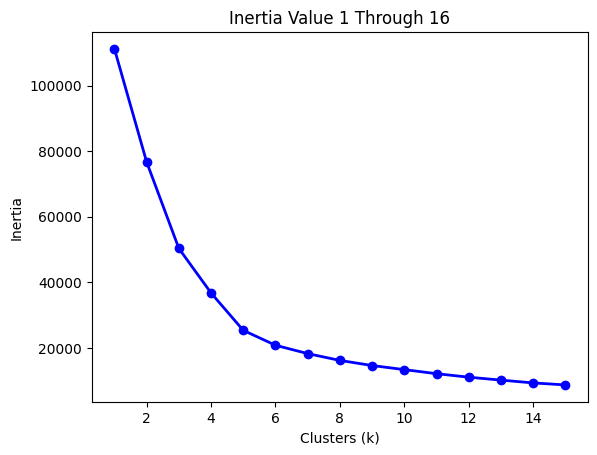

In [12]:
# Plotting the inertia values for different k
plt.plot(range(1, 16), inertia_values, marker='o', linewidth=2, color='blue')
plt.title('Inertia Value 1 Through 16')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')

plt.show()

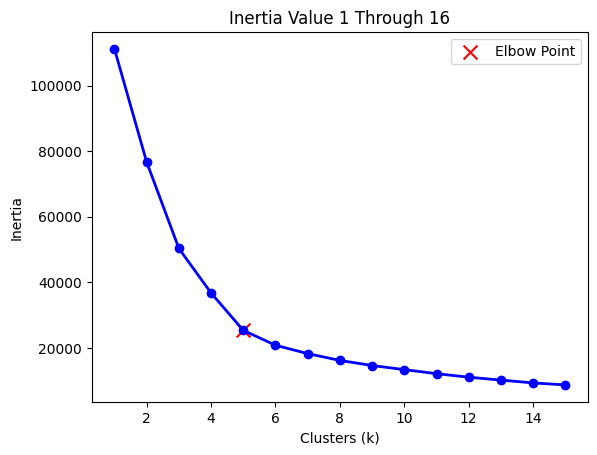

In [13]:
# Showing the Elbow Point
elbow_point = 5

# Plotting the inertia values for different k
plt.plot(range(1, 16), inertia_values, marker='o', linewidth=2, color='blue')
plt.title('Inertia Value 1 Through 16')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')

# Marking the Elbow Point
plt.scatter(elbow_point, inertia_values[elbow_point-1], color='red', marker='x', s=100, label='Elbow Point')

plt.legend()
plt.show()

In [14]:
# Training K-means with k = 5
elbow_k = 5
kmeans_elbow = KMeans(n_clusters = elbow_k, random_state = 0, n_init = 10)
kmeans_elbow.fit(X_normalized)

# Centroids Normalized
elbow_centroids_normalized_scale = kmeans_elbow.cluster_centers_

In [15]:
# Reporting the Size (Number of Items) of Each Cluster
cluster_sizes = pd.Series(kmeans_elbow.labels_).value_counts().sort_index()
print(f"Cluster Sizes:\n {cluster_sizes}")

Cluster Sizes:
 0    23175
1    10639
2     3177
3       10
4       57
Name: count, dtype: int64


In [16]:
# Reporting the Mean of Each Cluster in the Original Scale
elbow_original_scale = pd.DataFrame(scaler.inverse_transform(kmeans_elbow.cluster_centers_), columns=rfm_features)
print(f"CLUSTERS MEAN IN ORIGINAL SCALE:\n {elbow_original_scale}" )

CLUSTERS MEAN IN ORIGINAL SCALE:
    dollar_roll_sum_7D  quantity_roll_sum_7D  last_visit_ndays
0          836.477008             10.007031         14.174877
1          927.477113             10.117586        114.877056
2         4493.867823             39.699685         18.667823
3        19804.400000            972.800000          3.600000
4        35457.385965            165.982456         10.543860


In [17]:
# Reporting the Standard Deviation of Each Cluster in the Z-Normalized Scale
cluster_mean = pd.DataFrame(index=range(elbow_k), columns=rfm_features)
for x in range(elbow_k):
    x_data = churn_roll.loc[kmeans_elbow.labels_ == x, rfm_features]
    cluster_mean.loc[x] = x_data.std()

print(f"\nCLUSTER STANDARD DEVIATION IN Z-NORMALIZED SCALE:\n {cluster_mean}")


CLUSTER STANDARD DEVIATION IN Z-NORMALIZED SCALE:
   dollar_roll_sum_7D quantity_roll_sum_7D last_visit_ndays
0         671.084696             7.158225        13.943787
1          891.35654             8.639649        11.038113
2        2515.389073            19.788141        31.225534
3       10368.944479           281.553547         4.501851
4       14163.529663           106.340338         26.81289


In [18]:
# Random Cluster Choice of 1, 3, and 5
cluster_1 = churn_roll.loc[kmeans_elbow.labels_ == 0, rfm_features]
cluster_3 = churn_roll.loc[kmeans_elbow.labels_ == 2, rfm_features]
cluster_5 = churn_roll.loc[kmeans_elbow.labels_ == 4, rfm_features]

# Info for Cluster #1
print("****************************************")
print("CLUSTER 1")
print(f"\nSIZE: {cluster_sizes[0]}")
print(f"\nMEAN RFM VALUE IN ORIGINAL SCALE:\n{cluster_1.mean()}")
print(f"\nSTANDARD DEVIATION IN Z-NORMALIZED SCALE:\n{cluster_mean.loc[0]}")
print("****************************************")

# Info for Cluster #3
print("****************************************")
print("CLUSTER 3")
print(f"\nSIZE: {cluster_sizes[2]}")
print(f"\nMEAN RFM VALUE IN ORIGINAL SCALE:\n{cluster_3.mean()}")
print(f"\nSTANDARD DEVIATION IN Z-NORMALIZED SCALE:\n{cluster_mean.loc[2]}")
print("****************************************")

# Info for Cluster #5
print("****************************************")
print("CLUSTER 5")
print(f"\nSIZE: {cluster_sizes[4]}")
print(f"\nMEAN RFM VALUE IN ORIGINAL SCALE:\n{cluster_5.mean()}")
print(f"\nSTANDARD DEVIATION IN Z-NORMALIZED SCALE:\n{cluster_mean.loc[4]}")
print("****************************************")


****************************************
CLUSTER 1

SIZE: 23175

MEAN RFM VALUE IN ORIGINAL SCALE:
dollar_roll_sum_7D      835.962028
quantity_roll_sum_7D     10.002071
last_visit_ndays         14.172643
dtype: float64

STANDARD DEVIATION IN Z-NORMALIZED SCALE:
dollar_roll_sum_7D      671.084696
quantity_roll_sum_7D      7.158225
last_visit_ndays         13.943787
Name: 0, dtype: object
****************************************
****************************************
CLUSTER 3

SIZE: 3177

MEAN RFM VALUE IN ORIGINAL SCALE:
dollar_roll_sum_7D      4489.565943
quantity_roll_sum_7D      39.670444
last_visit_ndays          18.674221
dtype: float64

STANDARD DEVIATION IN Z-NORMALIZED SCALE:
dollar_roll_sum_7D      2515.389073
quantity_roll_sum_7D      19.788141
last_visit_ndays          31.225534
Name: 2, dtype: object
****************************************
****************************************
CLUSTER 5

SIZE: 57

MEAN RFM VALUE IN ORIGINAL SCALE:
dollar_roll_sum_7D      35457.385965


**SUMMARY**

<br>CLUSTER 1: 
<br>Cluster 1 represents a large group of customers who, on average, have relatively lower spending (Dollar Roll Sum 7D) and purchase quantities (Quantity Roll Sum 7D). The recency of visits (Last Visit nDays) is moderate. The standard deviations suggest that there is relatively low variability within this cluster.

CLUSTER 3:
<br>Cluster 3 represents a sizable group of customers with a higher average spending (Dollar Roll Sum 7D) and purchase quantities (Quantity Roll Sum 7D). However, the recency of visits (Last Visit nDays) is notably higher. The standard deviations suggest moderate variability within this cluster.

CLUSTER 5:
<br>Cluster 5 represents a moderate-sized group of customers with lower average spending (Dollar Roll Sum 7D) and purchase quantities (Quantity Roll Sum 7D). The recency of visits (Last Visit nDays) is moderate. The standard deviations suggest moderate variability within this cluster.